# Introduction
This notebook contains the numerical simulations for the paper ...

In [2]:
using Pkg

Pkg.activate("../.")

using Plots, DifferentialEquations
using Random, Statistics, Distributions, StatsPlots
using Optim, DelimitedFiles, LinearAlgebra
using LaTeXStrings, ColorSchemes

Plots.gr()

DiffEq = DifferentialEquations

include("../Notebooks/HelperScripts/temp_assembly.jl")


coef_var (generic function with 1 method)

## Assembly problem
Here we simulate the assembly of GLV systems at different temperatures. The broad idea here is to determine how well the analytical expressions for species richness hold across different temperatures ect.

Systems are assembled by first initialising the system and simulating till equilibrium. At equilibirium any extinct species are removed and a new species is added at low abundance. This is repeated untill the total simulation time limit is reached. 

First an test simulation.

In [72]:
include("../Notebooks/HelperScripts/temp_assembly.jl")

Random.seed!(1)

N = 2
x0 = rand(N)
tspan = (0, 1e5)

#growth rates
r_func(x...) = rand(LogNormal(1.0,0.2), x)
r = r_func(N)

#interactions - -0.5
ā = -0.5
int_func(x...) = rand(Normal(ā,0.1),x)
a = int_func(N,N)
[a[x,x] = -1.0 for x = 1:N]

p = Param(N,r,a,0.0)

cb = add_at_equi(int_func,r_func,abstol = 1e-6, reltol = 1e-6)
prob = DiffEq.ODEProblem(dx!, x0  , tspan, p)
sol = DiffEq.solve(prob, callback = cb, save_everystep = false);

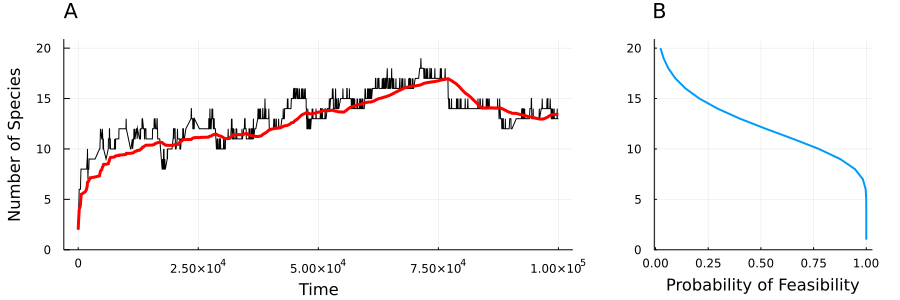

In [73]:
p1 = plot(sol.t, get_N(sol), colour = "black", ylim = (0, maximum(get_N(sol))*1.1 ),
            xlab = "Time", ylab = "Number of Species", title = "A", titleloc = :left,legend = false)

plot!(p1, sol.t,moving_avg(get_N(sol) , Int(floor(length(sol.u)/10))), colour = "red", linewidth = 3, legend = false)

#theory bound
N_vec = 1:1:Int(floor(maximum(get_N(sol))*1.1))

p_feas = p_feas_pred.(N_vec, ā, 1.0, 0.1)

#plot theory
p2 = plot(p_feas, N_vec, ylim = (0, maximum(get_N(sol))*1.1 ), linewidth = 2, xlab = "Probability of Feasibility", legend = false, title = "B", titleloc = :left)

# # #plot bounds
# N_sample = moving_avg(get_N(sol) , t_frame)[(end-t_frame):end]
# Plots.histogram!(N_sample, orientation = :horizontal, normalize = true)

p_final = plot(p1,p2, size = (900,300), layout = grid(1,2, widths = [0.7, 0.3]), margins = 5Plots.mm)
savefig(p_final, "../docs/Figures/Fig_3.pdf")

p_final

This plot shows the number of species over time in the assembled system. We can see from A that over time the system converges to a relatively stable number of species (with some dips as invasions cause extinctions). B shows the theoretical probabilty of feasabiltiy (obtained by considering the cumulative density function of the community generating distributions) These together show how the theoretically derived probabiltiy ot feasabiltiy matches the assembly simulations.

# Varying interaction strength

Next we vary the strength of interactions to see if the feasability bounds provided by the theory still work. One of the key preditctions of the thoery is that the number of species should decrease as interactions become more competitive. To test this we simulate systems across 3 levels of average interaction strength 

In [75]:
Random.seed!(1)

N = 2
x0 = rand(N)
tspan = (0, 5e4)

#simulation parameters
N_ā, N_rep = 3,10
ā_vec = range(-0.5,-0.25,length = N_ā)

res = Array{Any,2}(undef, N_ā, N_rep)

for i = 1:N_ā
    int_func(x...) = rand(Normal(ā_vec[i],0.1),x)

    for j = 1:N_rep
        #generate initial community params
        r = r_func(N)
        a = int_func(N,N)
        [a[x,x] = -1.0 for x = 1:N]
        p = Param(N, r, a, 0.0)

        #simulate
        prob = DiffEq.ODEProblem(dx!, x0, tspan, p)
        sol = DiffEq.solve(prob, callback = cb, save_everystep = false)
        res[i,j] = sol        
    end
end

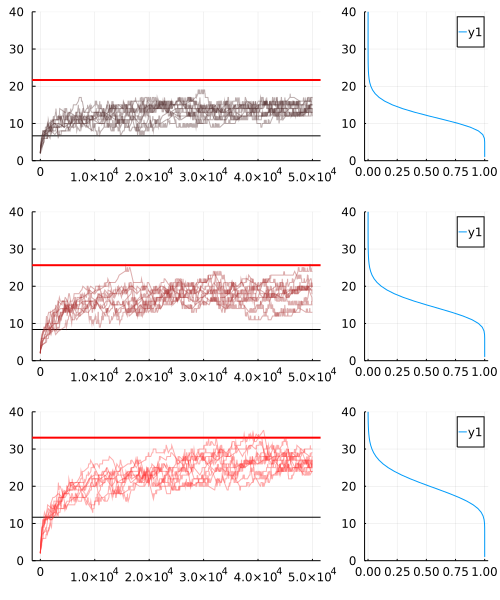

In [76]:
#get N_species
N_mat = map(get_N,res)
t_mat = map(x -> x.t, res)

N_vec = 1:1:40


#Plot N vs time
plts = Vector{Any}(undef, N_ā)

for i = 1:N_ā
    p_time = plot(legend = false)
    
    #theory bound
    bound = p_feas_pred.(N_vec, ā_vec[i], 1.0, 0.1)
    p_bound = plot(bound, N_vec)
    
    #solve for pN = 0.25
    f(N) = abs(p_feas_pred(N, ā_vec[i], 1.0, 0.1) - 0.01)
    opt_low = optimize(f, 0.0, 100.0, GoldenSection())
    hline!(p_time, [opt_low.minimizer], color = :red, lw = 2)

    g(N) = abs(p_feas_pred(N, ā_vec[i], 1.0, 0.1) - 0.99)
    opt_high = optimize(g, 0.0, 100.0, GoldenSection())
    hline!(p_time, [opt_high.minimizer], color = :black)

    
    for j = 1:N_rep
        plot!(p_time, t_mat[i,j], N_mat[i,j], color = RGBA(255*(i/N_ā)/255, 50/255 , 50/255,0.4))
        
    end
    
    plts[i] = plot(p_time, p_bound, layout = grid(1,2, widths = (0.7,0.3)))
end


plot(plts..., ylim = (0,40), layout = (N_ā,1), size = (500,600))

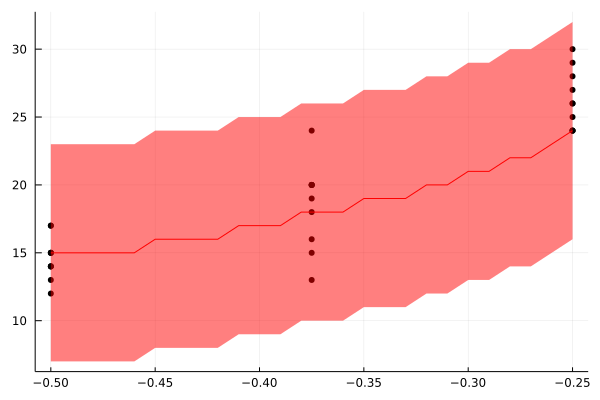

In [77]:
#plot end biomass
p1 = scatter(ā_vec, map(x -> x[end], N_mat), legend = false,  color = "black")

#Plot theory bound
N_vec = 1:1:40
ā_vec_cont = -0.5 : 0.01 : -0.25
p_feas = hcat([p_feas_pred.(N_vec, x, 1.0, 0.1) for x = ā_vec_cont]...)

#get midpoint
mean_N = N_vec[mapslices(x -> findmin(x)[2], abs.(p_feas .- 0.25), dims = 1)]

#get .95
σ_N = abs.(mean_N .- N_vec[mapslices(x -> findmin(x)[2], abs.(p_feas .- 0.005), dims = 1)])

plot!(ā_vec_cont, mean_N', ribbon = σ_N , color = "red")
# p2 = plot(p_feas, N_vec, ylim = (1,30))

# plot(p1,p2, size = (900,300), layout = grid(1,2, widths = [0.7, 0.3]), margins = 5Plots.mm, legend = false)

## Temperature

So what happens when we alter temperature in the system?

In [90]:
#simulations are done in "./HelperScripts/Temp_assembly_simulations.jl"

N_mat = Array{Any,3}(undef, 15, 10, 3)
t_mat = Array{Any,3}(undef, 15, 10, 3)
p_mat = Array{Any,3}(undef, 15, 10, 3)

for i = 1:3
    print(i)
    #parse N_sp
    N_mat_temp = readdlm( join( ["HelperScripts/Data/N_",i,".csv"] ), ',' )
    N_mat_temp = Meta.parse.(N_mat_temp) .|> eval
    N_mat[:,:,i] .= N_mat_temp
    
    #parse t
    t_mat_temp = readdlm( join( ["HelperScripts/Data/t_",i,".csv"] ), ',' )
    t_mat_temp = Meta.parse.(t_mat_temp) .|> eval
    t_mat[:,:,i] .= t_mat_temp
    
    #parse r
    params_mat_temp =  readdlm( join( ["HelperScripts/Data/params_",i,".csv"] ), ',' )
    params_mat_temp = Meta.parse.(params_mat_temp) .|> eval
    p_mat[:,:,i] .= params_mat_temp
end

123

In [91]:
function get_N_pred(ā,σr,p)
    f(N) = abs(p_feas_pred(N,ā,1.0,σr) - p)
    N = findmin(f.(1:1000))[2]
    #need a way to choose the search space apriori
#     opt = optimize(f, 0.0, 100.0, GoldenSection())

#     return(opt.minimizer)
end

get_N_pred (generic function with 1 method)

In [102]:
θ = 0.01
θl, θu = θ * 0.9 , θ * 1.1

N_pred_mean = [get_N_pred(x[1],x[2],θ) for x = p_mat]
N_pred_mean = mean(N_pred_mean, dims = 2)[:,1,:];

N_pred_u = [get_N_pred(x[1],x[2],θu) for x = p_mat]
N_pred_u = mean(N_pred_u, dims = 2)[:,1,:] .- N_pred_mean

N_pred_l = [get_N_pred(x[1],x[2],θl) for x = p_mat]
N_pred_l = N_pred_mean .- mean(N_pred_l, dims = 2)[:,1,:];

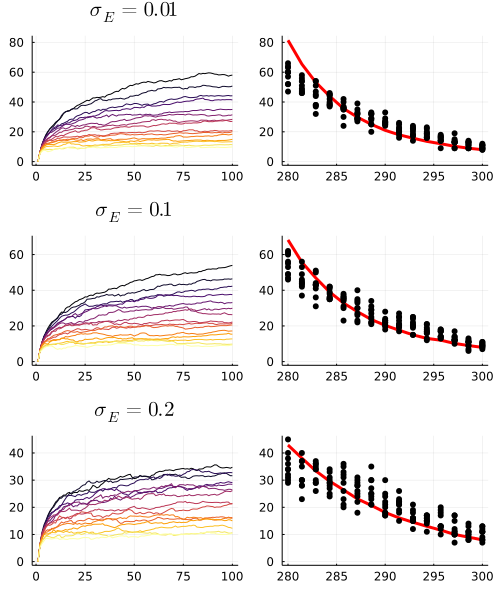

In [117]:
nanmean(x) = mean(filter(!isnan,x))

#binning time
N_t, N_T = 100, 15

t_vec = range(0,2e5,length = N_t)
T_vec = range(280,300,length = N_T)

plot_vec = Vector{Any}(undef,3)

σ_vec = [0.01, 0.1, 0.2]

for σ_i = 1:3
    #results
    res = zeros(N_T, N_t)
    for t = 2:N_t
        t_mat_time = map(x -> t_vec[t-1] .< x .< t_vec[t], t_mat[:,:,σ_i])
        N_avg = [mean(N_mat[i,j,σ_i][t_mat_time[i,j]]) for i = 1:size(N_mat)[1], j = 1:size(N_mat)[2]]
        res[:,t] = mapslices(nanmean, N_avg, dims = 2)
    end

    x = σ_vec[σ_i]
    
    p1 = plot(res', legend = false, line_z = T_vec',title = L"\sigma_{E} = %$x")
    p2 = plot(T_vec, N_pred_mean[:,σ_i], colour = "red", linewidth = 3, ribbon = (N_pred_l[:,σ_i], N_pred_u[:,σ_i]))
    scatter!(p2, T_vec, map(x -> x[end], N_mat[:,:,σ_i]), legend = false, color = "black")
    
    plot_vec[σ_i] = plot(p1,p2, link = :y)
end

plot(plot_vec... , layout = grid(3,1), size = (500, 600))

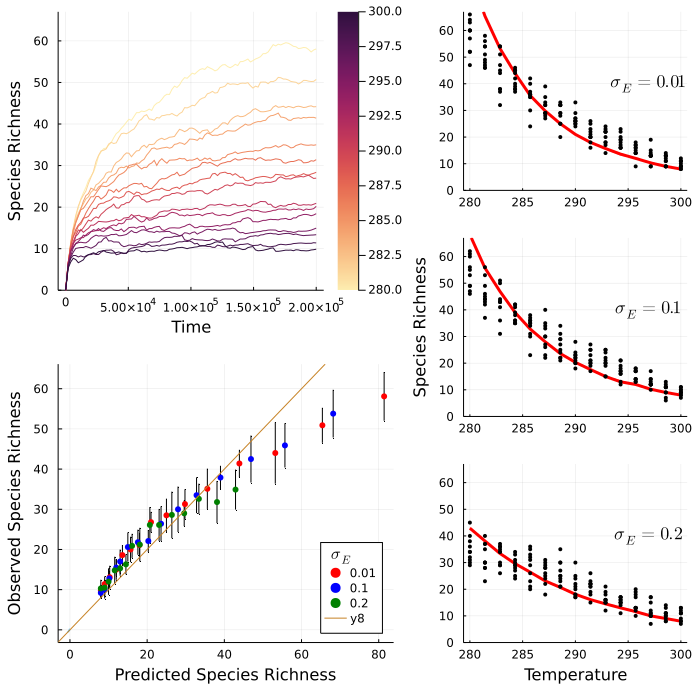

In [120]:
#Manuscript plot
#Plot 1: Assembly Time series
ylim = (0, (map(x -> x[end] ,N_mat) |> maximum) + 1)

#results
res = zeros(N_T, N_t)
for t = 2:N_t
    t_mat_time = map(x -> t_vec[t-1] .< x .< t_vec[t], t_mat[:,:,1])
    N_avg = [mean(N_mat[i,j,1][t_mat_time[i,j]]) for i = 1:size(N_mat)[1], j = 1:size(N_mat)[2]]
    res[:,t] = mapslices(nanmean, N_avg, dims = 2)
end

p1 = plot(t_vec, res', legend = false, colorbar = true, line_z = T_vec', color = :matter, ylim = ylim)
xlabel!(p1, "Time")
ylabel!(p1, "Species Richness")

#Plot 2: Temperature vs Nsp
p_list = Vector{Any}(undef, 3)
for σ_i = 1:3
    N_vec = map(x -> x[end] , N_mat[:,:,σ_i])
    p_temp = plot(T_vec, N_pred_mean[:,σ_i], colour = "red", linewidth = 3, ribbon = (N_pred_l[:,σ_i], N_pred_u[:,σ_i]))
    scatter!(p_temp, T_vec, N_vec, legend = false, color = "black", markersize = 3)
    
    x = σ_vec[σ_i]
    annotate!(p_temp, 297.0, 40.0, Plots.text(L"\sigma_{E} = %$x", 12))
    
    if σ_i == 3
        xlabel!(p_temp, "Temperature")
    end
    
    if σ_i ==2
        ylabel!(p_temp, "Species Richness")
    end

    p_list[σ_i] = p_temp
end

p2 = plot(p_list..., layout = grid(3,1), ylim = ylim)

#Plot 3: Predicted vs Observed
#Bound
N_pred_bound = reshape(N_pred_u,(N_T*3))
N_pred_bound_l = reshape(N_pred_l,(N_T*3))
N_pred_bound_u = reshape(N_pred_u,(N_T*3))
p3 = plot(N_pred_bound, N_pred_bound, ribbon = (N_pred_bound_l, N_pred_bound_u), legend = false, label = nothing)

#observations
N_obs_μ = mean(map(x -> x[end], N_mat),dims = 2)[:,1,:]
N_obs_σ = std(map(x -> x[end], N_mat),dims = 2)[:,1,:]
# labels = L"\sigma_{E} = %$x"
scatter!(p3, N_pred_mean, N_obs_μ, yerror = N_obs_σ, markerstrokewidth = 1.0, markerstrokealpha = 0.1, markersize = 1, legend = false, label = nothing)
scatter!(p3, N_pred_mean, markercolor = [:red :blue :green], N_obs_μ,legend = :bottomright, label = σ_vec', legendtitle = L"\sigma_{E}", markerstrokewidth = 0.0)
Plots.abline!(1,0)

xlabel!(p3, "Predicted Species Richness")
ylabel!(p3, "Observed Species Richness")



#combining
l = @layout [[a ; b] c{0.4w}]

p_final = plot(p1,p3,p2, layout = l, size = (700,700))
savefig(p_final, "../docs/Figures/Fig_4.pdf")

p_final

# non-assembly


In [164]:
#simulations are done in "./HelperScripts/Temp_assembly_simulations.jl"

N_mat = Array{Float64,3}(undef, 25, 5, 3)
t_mat = Array{Any,3}(undef, 25, 5, 3)
p_mat = Array{Any,3}(undef, 25, 5, 3)

for i = 1:3
    print(i)
    #parse N_sp
    N_mat_temp = readdlm( join( ["HelperScripts/Data/Non_assembly/N_",i,".csv"] ), ',' )
#     N_mat_temp = Meta.parse.(N_mat_temp) .|> eval
    N_mat[:,:,i] .= N_mat_temp
    
    #parse t
    t_mat_temp = readdlm( join( ["HelperScripts/Data/Non_assembly/t_",i,".csv"] ), ',' )
    t_mat_temp = Meta.parse.(t_mat_temp) .|> eval
    t_mat[:,:,i] .= t_mat_temp
    
    #parse r
    params_mat_temp =  readdlm( join( ["HelperScripts/Data/Non_assembly/params_",i,".csv"] ), ',' )
    params_mat_temp = Meta.parse.(params_mat_temp) .|> eval
    p_mat[:,:,i] .= params_mat_temp
end

123

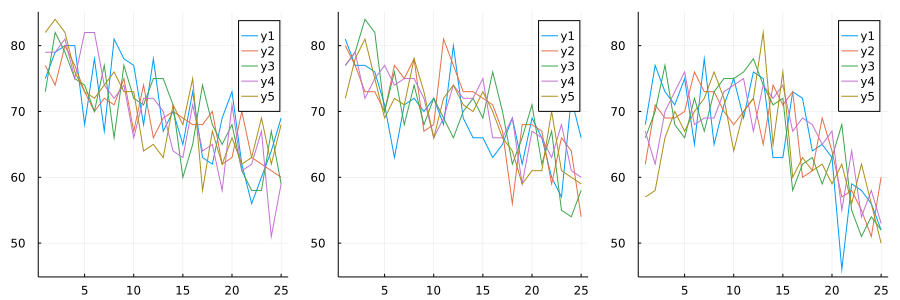

In [165]:
plot(plot(N_mat[:,:,1]),plot(N_mat[:,:,2]),plot(N_mat[:,:,3]), link = :y, layout = (1,3), size = (900,300))

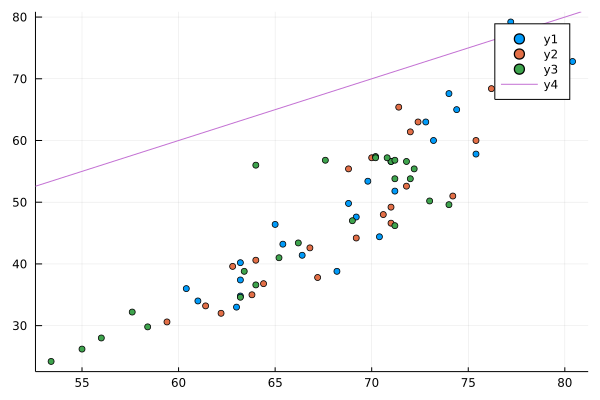

In [203]:
θ = 0.0001

N_pred_mean = [get_N_pred(x[1],x[2],θ) for x = p_mat]
N_pred_mean = mean(N_pred_mean, dims = 2)[:,1,:];

N_mat_mean = mean(N_mat, dims = 2)[:,1,:]

scatter(N_mat_mean,N_pred_mean)
Plots.abline!(1,0)

## Mean-field Approximation

Here we test how well the mean-feild model approximates the GLV dynamics, especially the equilibrial biomass across poulations.

In [20]:
Random.seed!(1)

N = 100
r = rand(N) .+ 2
a = -2*rand(N,N) ./ N
[a[i,i] = -1 for i = 1:N]
a_bar = mean((sum(a, dims = 2) .+ 1)/(N-1))

p = param(N,r,a)
p_mean = param_mean(N,r,a,a_bar)


x0 = ones(N)
tspan = (0.0,10.0)

prob = ODEProblem(dx!,x0,tspan,p)
sol = DiffEqBase.solve(prob, Vern7() )

prob_mean = ODEProblem(dx_mean!,x0,tspan,p_mean)
sol_mean = DiffEqBase.solve(prob_mean, Vern7() )

p1 = plot(sol, legend = false)
p2 = plot(sol_mean, legend = false)
p3 = scatter(sol[end],sol_mean[end], legend = false)
plot!(p3, [minimum(sol[end]), maximum(sol_mean[end])], [minimum(sol[end]),maximum(sol_mean[end])])

plot(p1,p2,p3, layout = (1,3), size = (900,400))

In [55]:
function f(sol,t)
    μC = mean(sol(t))
    dμC = mean(sol(t) .* sol.prob.p.r .+  sum((sol(t) .* sol(t)'.* sol.prob.p.a),dims = 1)')
    
    V1 = sum( sol(t) .- sol[end] .- sol[end] .* log.(sol(t) ./ sol[end]) )
    V2 = sqrt(sum( sol(t) .^2  ))
    
    return([μC, dμC, V1, V2])
end

#simulate many times from differnt starting points
N_sim = 100
x_eq = mean(equi_app(p))
x_real = mean(sol[end])
t_vec = range(0,tspan[end],length = 100)

sol_vec = Vector{Any}(undef, N_sim)


i = 1
for i = 1:N_sim
    μ = x_eq * range(0.99,1.01,length = N_sim)[i]
    x0 = abs.(rand(Normal(μ,0.1),p.N))
    prob = ODEProblem(dx!,x0,tspan,p)
    sol = DiffEqBase.solve(prob, Vern7() )
    sol_vec[i] = hcat(f.(Ref(sol), t_vec)...)
end

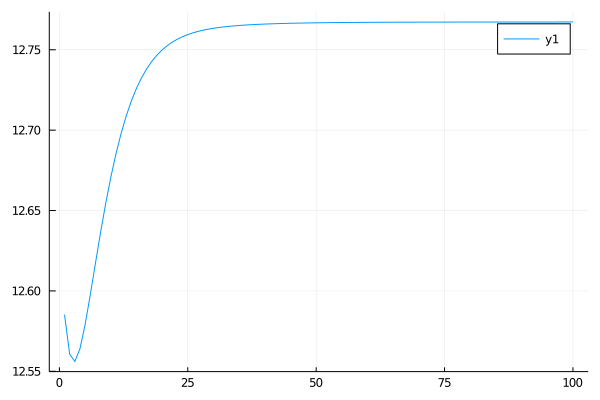

In [60]:
plot(sol_vec[1][4,:])

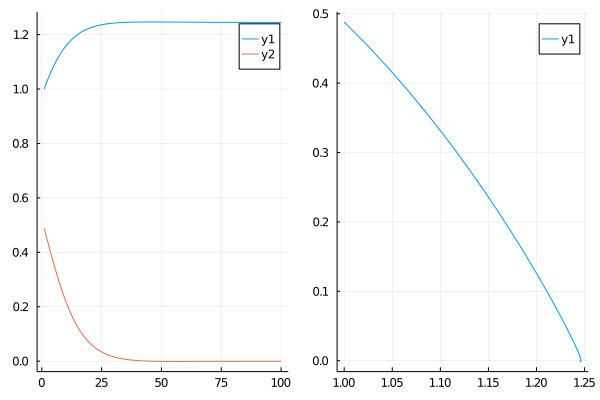

In [392]:
t_vec = range(0,tspan[end],length = 100)
x = f.(Ref(sol),t_vec)
res = hcat(x...)'

p1 = plot(res)
p2 = plot(res[:,1],res[:,2])

plot(p1,p2)

In [170]:
function dC!(dC,C,p,t)
    dC[1] = C[1] * ( p.r[1] + (p.a[1,1] * C[1]) + (p.a[1,2] * C[2]))
    dC[2] = C[2] * ( p.r[2] + (p.a[2,2] * C[2]) + (p.a[2,1] * C[1]))
    dC[3] = dC[1] + dC[2]
end

struct pair_params
    r::Vector{Float64}
    a::Array{Float64,2}
end

In [341]:
r = [1.0,1.0]
a = [-1.0 -0.4;
     0.2 -1.0]

p_pair = pair_params(r,a)


C0 = [0.1, 0.1, 0.2]

tspan = (0.0,10.0)

prob = ODEProblem(dC!,C0,tspan,p_pair)
sol = DiffEqBase.solve(prob, Vern7() );

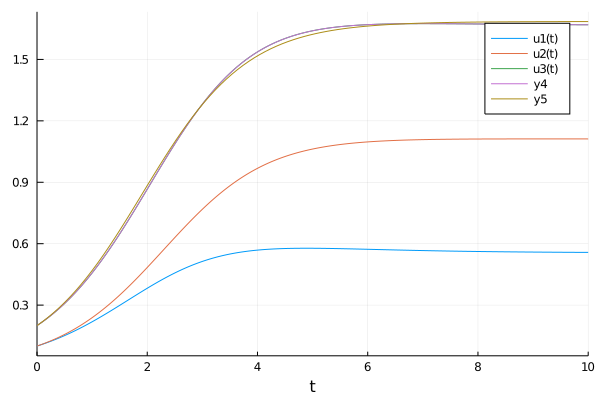

In [342]:
#fit biomass curves
t_vec = range(0.0,tspan[2],length = 100)

C_tot = sum(hcat(sol.(t_vec)...)[1:2,:],dims = 1)[:]
m(t, p) = (p[1] .* 0.2) ./ (0.2 .+ ( (p[1]-0.2) .* exp.(-p[2] .* t)) )

p0 = [0.2, 2.0, 1.0]

fit_tot = curve_fit(m,t_vec,C_tot,p0)

plot(sol)
plot!(t_vec, C_tot)

plot!(t_vec, m(t_vec, fit_tot.param))

In [343]:
function get_a(sol, t)
    C = sol(t)[1:2]
    C_tot = sum(C)
    r = sol.prob.p.r
    a = sol.prob.p.a
        
    grw = (C[1] * r[1]) + (C[2] * r[2])
    intra = (C[1] * C[1] * a[1,1]) + (C[2] * C[2] * a[2,2])
    inter = (C[1] * C[2] * a[1,2]) + (C[2] * C[1] * a[2,1]) 
    dC_tot = (C_tot * fit_tot.param[2]) * (1 - (C_tot/fit_tot.param[1]))
    
    a = (dC_tot - grw - intra) / (C[1] * C[2])
    
    return(a)
end


get_a (generic function with 1 method)

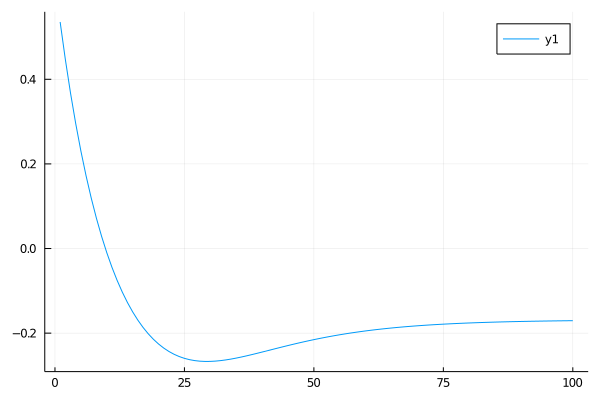

In [345]:
# plot(t_vec,hcat(sol.(t_vec,Val{1})...)')
# plot!(t_vec, get_a.(Ref(sol),t_vec))
#

plot(hcat(get_a.(Ref(sol),t_vec)...)')

In [292]:
a[1,1] * C[1]

-0.2285785092286735

In [316]:
w = [0.425,1.149]
p = [319.94,237.60]

(sum(w .* p) / sum(w))

259.8328462515883